# Tentativa e Erro - Seleção de Modelo

### Este notebook tem como objetivo apresentar todo o processo prático da escolha do modelo de aprendizado de máquina referente ao case do processo seletivo da XP Inc. 

## Disposições gerais

Por abraçar o erro ao invés de escondê-lo, algumas células poderão causar erros na execução. Também não existe um tamanho de arquivo ideal; todas as soluções tentadas serão registradas independente de quantas ou seu resultado. A expectativa é que, ao analisar este notebook, toda a minha linha de pensamento até a solução aceitável (se houver) possa ser compreendida.

No momento de escrita desta linha, possuo experiência prática com os algoritmos de árvores de decisão e regressão linear. Também possuo experiência teórica relevante com KNN, SVM e K-Means. Por último, possuo experiência limitada com algoritmos de aprendizado profundo. [Pelo](https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/) que [afirmam](https://labelyourdata.com/articles/stock-market-and-machine-learning) fontes, algoritmos de aprendizado profundo seriam os ideais para resolver problemas como este na vida real.

## Passo 0 - Preparo dos dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib. pyplot as plt
import matplotlib

In [2]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score

In [111]:
# O objetivo desta sessão é pegar os dados desordenados e deixá-los prontos para uso

df=pd.read_csv("stockData.csv", na_values=['null'],parse_dates=True,infer_datetime_format=True)
df

,Company,FullName,Date,Open,High,Low,Close,Volume,OpenInt
0,AAPL,Apple,2017-01-03,52.488,52.827,52.378,52.663,84271282,0
1,AAPL,Apple,2017-01-04,52.516,53.105,52.414,52.946,72548556,0
2,AAPL,Apple,2017-01-05,53.140,53.599,52.849,53.534,75572081,0
3,AAPL,Apple,2017-01-06,53.757,54.138,53.687,54.094,88773291,0
4,AAPL,Apple,2017-01-09,54.491,54.778,53.959,54.008,109831110,0
...,...,...,...,...,...,...,...,...,...
210825,GPN,Global Payments,2022-11-06,103.770,104.830,103.619,104.270,1097421,0
210826,GPN,Global Payments,2022-11-07,104.400,104.400,103.160,103.900,1252807,0
210827,GPN,Global Payments,2022-11-08,103.110,103.750,100.040,101.650,2263410,0
210828,GPN,Global Payments,2022-11-09,101.300,101.330,97.900,99.320,1781658,0


A seguir, temos uma decisão de projeto importante que merece ser pensada e discutida previamente. Os modelos serão usados para descobrir a melhor forma de comprar e vender as ações. Por mais que apresentem similaridades no uso dos dados numéricos, os modelos diferem no objetivo final. Em essência, o modelo de compra visa prever a companhia com maior valorização entre hoje e uma data fixada enquanto o modelo de venda busca prever a data em que uma ação chegará a seu maior valor.

Essa distinção afeta diretamente na forma como os dados serão tratados, principalmente quando se leva em consideração que o fator variável provavelmente possui influência no preço e existe um ganho potencial de incluí-lo na análise.

Neste contexto, possibilidades foram levantadas. As óbvias são agrupar por alguma forma (facilita o trabalho de um modelo enquanto dificulta o outro), agrupar de ambas as formas e exportar para csvs diferentes (ao custo de dobrar o processamento de algo que já deve incluir milhões de dados). Também é possível limpar os dados e deixar que cada modelo decida o que fazer, ao custo de um processamento um pouco maior.

A decisão escolhida para o projeto final, no primeiro momento, é a última. Porém, nas tentativas e erros da primeira versão, será testado o cenário de agrupamento por companhia visando prever o preço em uma determinada data. Este modelo não soluciona nenhum dos problemas apresentados de forma direta, mas em ambos os casos soluções podem ser obtidas a partir da composição de soluções do modelo simplificado. Para algoritmos de aprendizado de máquina que escalam muito rápido em complexidade, é importante manter-se aberto à possibilidade de mantê-los simples e obter resultados complexos a partir de combinações.

In [112]:
# Primeiro passo, remover as coluna company (redundante com FullName) e OpenInt (desnecessária)
filtered_columns = df.drop(columns = ['Company', 'OpenInt']).sort_values(by = "Date")
filtered_columns


,FullName,Date,Open,High,Low,Close,Volume
0,Apple,2017-01-03,52.4880,52.8270,52.3780,52.6630,84271282
33889,Barclays,2017-01-03,9.1999,9.4240,9.1912,9.2931,5515413
185738,Chipotle Mexican Grill,2017-01-03,343.7000,350.4900,340.0000,341.2700,728093
35365,Brandywine Realty Trust,2017-01-03,7.4194,7.5758,7.3332,7.4036,1538256
184262,Devon Energy,2017-01-03,59.6550,61.2540,59.1570,60.8060,5952293
...,...,...,...,...,...,...,...
169501,Suncor Energy,2022-11-10,36.2100,36.4800,35.9700,36.4200,3287248
56024,Bank of Montreal,2022-11-10,77.7800,77.7800,76.8500,77.2200,214921
160645,NXP Semiconductors,2022-11-10,115.2600,116.2500,115.0400,116.0500,2392787
85370,Coca-Cola,2022-11-10,46.2000,46.6400,46.1350,46.5400,8022883


In [113]:
filtered_columns["Date"] = filtered_columns["Date"].apply(lambda date: date.replace("-",""))

In [114]:
# filtered_columns

In [115]:
filtered_columns_1 = filtered_columns.loc[(filtered_columns["Date"] < "2020-01-01")].set_index("Date").sort_values(by = "Date")
filtered_columns_1

,FullName,Open,High,Low,Close,Volume
Date,,,,,,
20170103,Apple,52.488,52.827,52.378,52.663,84271282
20170103,Petrobras,24.131,25.044,24.074,24.826,13414486
20170103,Target,43.792,43.807,42.845,43.142,9038799
20170103,Southern Company,35.279,35.449,34.487,34.655,9102867
20170103,Intuitive Surgical,157.000,157.980,155.720,157.240,1033566
...,...,...,...,...,...,...
20191231,Waste Management,47.788,47.982,47.362,47.399,2423984
20191231,Unilever,37.351,37.378,36.940,36.969,475540
20191231,Intuitive Surgical,176.060,178.670,175.140,176.310,447693


In [116]:
filtered_columns_2 = filtered_columns.loc[(filtered_columns["Date"] >= "2020-01-01")].set_index("Date").sort_values(by = "Date")
filtered_columns_2

,FullName,Open,High,Low,Close,Volume
Date,,,,,,
20200102,Abbott Laboratories,42.235,42.422,41.664,41.908,3446924
20200102,Oracle,42.983,43.194,42.029,42.371,15766697
20200102,Boeing,120.300,120.990,118.460,119.270,4679018
20200102,Cadence Design Systems,19.150,19.240,18.570,18.830,3508565
20200102,Edward Lifesciences,64.095,64.905,63.305,63.860,1215780
...,...,...,...,...,...,...
20221110,Devon Energy,41.000,41.020,40.010,40.410,4437430
20221110,Johnson & Johnson,140.130,140.130,138.610,139.560,4240286
20221110,Tesla,302.500,308.360,301.850,302.990,4621912


In [117]:
print(filtered_columns_1["FullName"].unique())

['Apple' 'Petrobras' 'Target' 'Southern Company' 'Intuitive Surgical'
 'Dominion Energy' 'Micron Technology' 'Fomento Económico Mexicano'
 'Canadian Pacific Railway' 'HDFC Bank' 'Edward Lifesciences'
 'Goldman Sachs' 'Waste Management' 'Netflix' 'Global Payments'
 'Starbucks' 'Cisco' '3M' 'IBM' 'Vale' 'HSBC' 'NetEase'
 'Royal Bank Of Canada' 'Honeywell' 'Texas Instruments'
 'Toronto Dominion Bank' 'Nextera Energy' 'Intel' 'QUALCOMM' 'Fedex'
 'Nike' 'Fidelity National Information Services'
 'Canadian Natural Resources' 'Occidental Petroleum' 'Unilever'
 'Johnson & Johnson' 'Ecolab' 'Ford' 'Astrazeneca' 'Synopsys'
 'Marathon Petroleum' 'Pepsico' 'National Grid' 'Oracle' 'Pfizer'
 'Mastercard' 'Wallmart' 'Sempra Energy' 'Coca-Cola' 'Ambev'
 'Vertex Pharmaceutical' 'Vmware' 'Visa' 'General Motors' 'Exxon Mobil'
 'Tesla' 'NXP Semiconductors' 'Microsoft' 'Cadence Design Systems'
 'Cheesecake Factory Inc' 'Canon' 'McDonald' 'The Hershey Company'
 'Capital One' 'Citigroup' 'Compania de Minas B

In [118]:
print(filtered_columns_2["FullName"].unique())

['Abbott Laboratories' 'Oracle' 'Boeing' 'Cadence Design Systems'
 'Edward Lifesciences' 'Mastercard' 'C3.ai Inc' 'Mercado Livre' 'Apple'
 'Brandywine Realty Trust' 'Fedex' 'Target' 'Starbucks'
 'Cognizant Technology Solutions'
 'Foreign Trade Bank of Latin America Inc' 'Canadian Natural Resources'
 'Brooklyn Immunotherapeutics Inc' 'Sempra Energy' 'Vmware'
 'Goldman Sachs' 'Newmont' 'Apartment Investment and Management Co'
 'Bank of America' 'Black Hills Corp' 'Bionovate Technologies Corp'
 'Waste Management' '3M' 'Dominion Energy' 'Valero Energy'
 'Hewlett Packard' 'NetEase' 'HDFC Bank' 'Adobe' 'B&G Foods Inc' 'Ford'
 'Chipotle Mexican Grill' 'Cheesecake Factory Inc' 'Cenovus Energy'
 'Motorola Solutions' 'Cisco' 'Nextera Energy' 'Accenture' 'Honeywell'
 'HSBC' 'Ambev' 'Unilever' 'Pepsico' 'Astrazeneca' 'Electronic Arts'
 'McDonald' 'Exxon Mobil' 'BlackRock' 'Southern Company'
 'Republic Services' 'NXP Semiconductors' 'Abercrombie & Fitch Co'
 'Cardinal Health Inc' 'Automatic Data Pr

In [120]:
# Exportando os dados filtrados
filtered_columns.to_csv('./filteredStocks.csv')
filtered_columns_1.to_csv("./filteredStocks_1.csv")
filtered_columns_2.to_csv("./filteredStocks_2.csv")

In [72]:
# Listando todas as companhias no dataFrame
name_list = train_data['FullName'].unique()
pd.Series(name_list)

0      Agilent Technologies Inc
1           Activision Blizzard
2                 APA Corp (US)
3                 EOG Resources
4         Ampco-Pittsburgh Corp
                 ...           
404          ADMA Biologics Inc
405                         UBS
406     Abeona Therapeutics Inc
407        Associated Banc-Corp
408             Great Ajax Corp
Length: 409, dtype: object

In [66]:
# Agrupando por empresa para utilizar nos experimentos
data = dict();
for name in name_list:
    data[name] = train_data.loc[train_data["FullName"] == name].drop(columns=["FullName"])
data[name_list[0]]

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,22.545,22.669,22.147,22.615,5623678
2012-01-04,22.648,22.834,22.526,22.675,4446113
2012-01-05,22.580,23.268,22.580,23.268,5100148
2012-01-06,23.289,23.484,23.012,23.392,6512959
2012-01-09,23.392,23.492,23.234,23.323,4326418
...,...,...,...,...,...
2022-06-24,43.909,44.407,43.277,43.475,5341774
2022-06-27,42.992,43.071,41.366,41.643,4392611
2022-06-28,42.046,42.479,41.538,42.479,4364683


## Tentativa 1 - Tensor Flow [Fonte](https://www.analyticsvidhya.com/blog/2021/10/machine-learning-for-stock-market-prediction-with-step-by-step-implementation/)

#### Antes de tentar implementar uma solução para o meu problema, tento replicar uma solução que encontrei na internet. O objetivo é entender como e principalmente por que (não) funciona para então usar os aprendizados no meu problema

In [9]:
# Importações necessárias
from Keras. Models import Sequential
from Keras. Layers import Dense
import Keras. Backend as K
from Keras. Callbacks import EarlyStopping
from Keras. Optimisers import Adam
from Keras. Models import load_model
from Keras. Layers import LSTM
from Keras. utils.vis_utils import plot_model

ModuleNotFoundError: No module named 'Keras'

Falha na importação que não foi possível resolver manipulando apenas o ambiente local. Dada a ênfase deste projeto em ser replicável no dispositivo dos avaliadores, tentativa 1 se mostra inviável. Porém será dado prosseguimento enfatizando a análise dos dados apresentada na fonte. Para fins de exemplo, será utilizado o frame correspondente aos dados da primeira companhia registrada no arquivo.

In [10]:
example_1 = data[name_list[0]]
example_1.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,475.38,479.04,466.72,478.19,1584953
2012-01-04,474.02,476.34,469.05,469.35,1928560
2012-01-05,469.92,473.24,469.54,471.67,1170221
2012-01-06,474.21,474.41,467.60,471.67,1412406
2012-01-09,471.47,472.84,468.56,469.44,1732500


In [11]:
print("Formato do DF", example_1. shape)
print("Existem valores nulos?", example_1.isnull().values.any())

Formato do DF (2642, 5)
Existem valores nulos? False


No exemplo utilizado pelo site, usam-se as variáveis Open, High, Low e Volume para prever a variável AdjClose que não está presente no nosso banco de dados. Por isso, a primeira tentativa será usar Open, Low, Close e Volume para detectar High. Eventualmente, testará-se também a possibildiade de inverter High com Low para então obter as perspectivas otimistas e pessimistas. 

<AxesSubplot:xlabel='Date'>

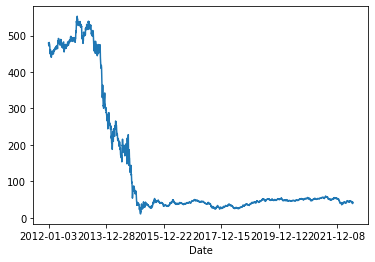

In [12]:
# Plotando o máximo e o mínimo

example_1['High'].plot()

<AxesSubplot:xlabel='Date'>

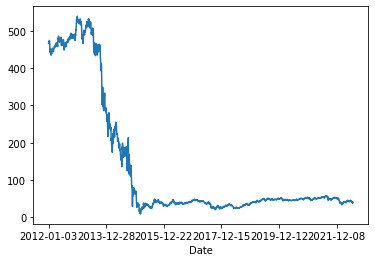

In [13]:
example_1['Low'].plot()

In [14]:
# Neste exemplo, vou preparar os dados para preverem a média
output_var = pd.DataFrame(example_1[ "High"])
# Informações usadas para as previsões
features = ["Open", "Close", "Low", "Volume"]

Para reduzir o custo de processamento dos dados, será utilizado um escalador para normalização dos dados
Mais informações sobre a relevância deste processo podem ser encontradas [aqui](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#:~:text=Feature%20scaling%20through%20standardization%20(or,a%20standard%20deviation%20of%20one). Em poucas palavras, este processo é essencial para impedir que dados naturalmente maiores possuam um peso maior na análise. Algoritmos de regressão (baseados em funções de minimização de erro) são particularmente sensíveis a isso. Por outro lado, algoritmos baseados em árvore de decisão não são afetados.

É importante também salientar o que são e qual a diferença entre normalização e estandardização ([fonte1](https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/), [fonte2](https://www.kdnuggets.com/2020/04/data-transformation-standardization-normalization.html)). Neste projeto, a não ser quando especificado o contrário, os termos devem ser tratados como sinônimos.

In [15]:
#Scaling
scaler = preprocessing.MinMaxScaler()
feature_transform = scaler.fit_transform(example_1[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=example_1.index)
feature_transform.head()

,Open,Close,Low,Volume
Date,,,,
2012-01-03,0.863280,0.871482,0.863680,0.007042
2012-01-04,0.860758,0.855031,0.868081,0.008569
2012-01-05,0.853154,0.859348,0.869006,0.005199
2012-01-06,0.861111,0.859348,0.865342,0.006275
2012-01-09,0.856029,0.855198,0.867155,0.007698


In [16]:
# Dividindo entre dados para treino e validação
porcentagem_teste = 20
# Importante usar o TimeSeriesSplit para garantir a ordem cronológica dos dados
timesplit= TimeSeriesSplit(n_splits=int(100/porcentagem_teste)-1)

for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [17]:
X_train

,Open,Close,Low,Volume
Date,,,,
2012-01-03,0.863280,0.871482,0.863680,0.007042
2012-01-04,0.860758,0.855031,0.868081,0.008569
2012-01-05,0.853154,0.859348,0.869006,0.005199
2012-01-06,0.861111,0.859348,0.865342,0.006275
2012-01-09,0.856029,0.855198,0.867155,0.007698
...,...,...,...,...
2020-05-21,0.066190,0.066455,0.068065,0.058528
2020-05-22,0.066080,0.066980,0.068208,0.058023
2020-05-23,0.066911,0.067253,0.068797,0.043690


In [18]:
X_test

,Open,Close,Low,Volume
Date,,,,
2020-05-29,0.067132,0.067235,0.069017,0.070992
2020-05-30,0.066837,0.067761,0.068909,0.052672
2020-06-02,0.067585,0.068102,0.069424,0.054269
2020-06-03,0.067418,0.068882,0.069481,0.073520
2020-06-04,0.068375,0.068320,0.070121,0.059682
...,...,...,...,...
2022-06-24,0.055411,0.055001,0.056216,0.326000
2022-06-27,0.053505,0.051686,0.053054,0.242532
2022-06-28,0.053920,0.055254,0.054699,0.175168


In [19]:
pd.DataFrame(y_train)

,0
0,479.040
1,476.340
2,473.240
3,474.410
4,472.840
...,...
2109,45.837
2110,45.896
2111,46.140
2112,47.064


In [20]:
pd.DataFrame(y_test)

,0
0,46.237
1,46.336
2,46.684
3,46.976
4,46.908
...,...
523,40.516
524,38.803
525,39.772
526,41.298


As etapas seguintes do tutorial giram em torno das bibliotecas que não puderam ser importadas. De lição da primeira tentativa, fica principalmente o preparo dos dados para os modelos que podem ser reaproveitadas.

## Tentativa 2 - RFC 

A segunda tentativa envolverá o algoritmo RFC (Random Forest Classifier) que eu já usei anteriormente para resolver problemas de classificação. Ele nada mais é do que uma combinação de árvores de decisão. A principal fonte a ser utilizada será a [documentação oficial](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). Dependendo do sucesso, outros algoritmos podem ser testados.

In [21]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(verbose = True)
clf.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous'

Terminada antes de começar, a segunda tentativa resulta em fracasso. Por mais que possa ser usado para algoritmos de regressão, o algoritmo de RFC necessita que os dados previstos sejam contínuos. Isso não o descarta completamente enquanto opção visto ser possível transformar a variável desejada em algo categórico, porém é necessário fazer uma busca sobre a possível existência de algoritmos mais eficientes antes de tentar encaixar meu problema ao algoritmo ao invés do contrário.

## Tentativa 3 - Lasso

Na dificuldade de selecionar um algoritmo, procurei a [documentação oficial do sci-kit learn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html). Isso traz a ideia de utilizar o algoritmo de Lasso visto que é o que melhor se encaixa na abordagem atual do problema. 

Um ponto importante aqui é que as decisões tomadas até então afetam diretamente a escolha dos algoritmos, em especial a forma de agrupar por empresas. A expectativa é que a quantidade de dados no final seja na casa de milhões; neste contexto, o algoritmo SGDRegression seria o recomendado. Ao dividir a tabela original em uma tabela por empresa para aplicar o algoritmo diretamente a elas, cria-se um contexto em que a quantidade de dados de teste não passará de 5 mil. Isso nos leva à aplicação do algoritmo de Lasso que nada mais é do que uma variação da regressão linear.

In [22]:
from sklearn import linear_model
clf = linear_model.Lasso()
clf.fit(X_train, y_train)

C:\Users\Leo\Desktop\Projetos\case-xp\data\env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.911e+03, tolerance: 7.179e+03
  model = cd_fast.enet_coordinate_descent(


Lasso()

A primeira tentativa não obteve resultados pela quantidade de dados. Este comportamento era esperado visto que já foi mencionado que modelos lineares não são bons para problemas da imprevisibilidade de mercado de ações. Porém, antes de tentar outra coisa, é necessário validar se alterar o número de iterações pode afetar a convergência

In [23]:
clf = linear_model.Lasso(max_iter = 10000)
clf.fit(X_train, y_train)

Lasso(max_iter=10000)

Com o problema de iterações resolvido, hora de fazer a previsão e comparar, tanto com as métricas inclusa no modelo como métricas [sugeridas pelo sci-kit learn](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics), começando com uma vizualização em tabela ordenada pelo erro, passando por métricas de distribuição estatística e culminando em métricas de desempenho

In [29]:
prediction_high = clf.predict(X_test)
diff = [prediction_high[i] - y_test[i] for i in range(0, np.size(prediction_high))]
frame_high = pd.DataFrame([prediction_high, y_test, diff]).transpose().sort_values(by=2)
frame_high.head(20)

,0,1,2
312,51.440775,51.257,0.183775
497,46.757304,45.160,1.597304
358,55.329628,53.627,1.702628
313,53.192847,51.470,1.722847
419,42.567510,40.716,1.851510
472,45.369289,43.504,1.865289
412,44.544017,42.670,1.874017
442,42.250079,40.374,1.876079
407,49.485902,47.601,1.884902
425,42.570607,40.649,1.921607


In [32]:
frame_high.tail(20)

,0,1,2
486,47.735217,44.860,2.875217
424,42.684355,39.808,2.876355
122,55.296902,52.419,2.877902
325,52.787078,49.909,2.878078
193,55.210053,52.331,2.879053
399,54.224752,51.342,2.882752
111,54.805757,51.923,2.882757
51,50.198414,47.308,2.890414
460,44.138109,41.246,2.892109
520,45.189209,42.297,2.892209


In [35]:
print("Erro Mediano: ", np.median(diff))
print("Erro Máximo: ", np.max(diff))
print("Erro Mínimo: ", np.min(diff))

Erro Mediano:  2.5686063047064707
Erro Máximo:  3.0237671861639654
Erro Mínimo:  0.18377542572653738


In [36]:

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_percentage_error

# Mean Absolute Error > Média dos erros absolutos
print("MAE ",np.mean(diff))
# Mean Absolute Percentual Error > Média percentual dos erros absolutos
print("MAPE", mean_absolute_percentage_error(y_test, prediction_high))
# Mean Squared Error > Média dos quadrados dos erros absolutos
print("MSE ", mean_squared_error(y_test, prediction_high))
print("R2  ", clf.score(X_test, y_test))

MAE  2.53114774630386
MAPE 0.05168515589568289
MSE  6.468909924522851
R2   0.7069108305773706


Antes de fazer uma análise dos resultados e tentar encaixá-la em uma narrativa, é prudente fazer o mesmo processo para tentar prever o valor mínimo das ações

In [37]:
output_var = pd.DataFrame(example_1[ "Low"])
features = ["Open", "Close", "High", "Volume"]
feature_transform = scaler.fit_transform(example_1[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=example_1.index)
feature_transform.head()

,Open,Close,High,Volume
Date,,,,
2012-01-03,0.863280,0.871482,0.863762,0.007042
2012-01-04,0.860758,0.855031,0.858786,0.008569
2012-01-05,0.853154,0.859348,0.853072,0.005199
2012-01-06,0.861111,0.859348,0.855228,0.006275
2012-01-09,0.856029,0.855198,0.852335,0.007698


In [38]:
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [39]:
X_train

,Open,Close,High,Volume
Date,,,,
2012-01-03,0.863280,0.871482,0.863762,0.007042
2012-01-04,0.860758,0.855031,0.858786,0.008569
2012-01-05,0.853154,0.859348,0.853072,0.005199
2012-01-06,0.861111,0.859348,0.855228,0.006275
2012-01-09,0.856029,0.855198,0.852335,0.007698
...,...,...,...,...
2020-05-21,0.066190,0.066455,0.065347,0.058528
2020-05-22,0.066080,0.066980,0.065456,0.058023
2020-05-23,0.066911,0.067253,0.065906,0.043690


In [40]:
X_test

,Open,Close,High,Volume
Date,,,,
2020-05-29,0.067132,0.067235,0.066084,0.070992
2020-05-30,0.066837,0.067761,0.066267,0.052672
2020-06-02,0.067585,0.068102,0.066908,0.054269
2020-06-03,0.067418,0.068882,0.067446,0.073520
2020-06-04,0.068375,0.068320,0.067321,0.059682
...,...,...,...,...
2022-06-24,0.055411,0.055001,0.055540,0.326000
2022-06-27,0.053505,0.051686,0.052383,0.242532
2022-06-28,0.053920,0.055254,0.054169,0.175168


In [41]:
pd.DataFrame(y_train)

,0
0,466.720
1,469.050
2,469.540
3,467.600
4,468.560
...,...
2109,45.449
2110,45.525
2111,45.837
2112,46.150


In [42]:
pd.DataFrame(y_test)

,0
0,45.953
1,45.896
2,46.169
3,46.199
4,46.538
...,...
523,39.175
524,37.501
525,38.372
526,40.036


In [45]:
clf.fit(X_train, y_train)
prediction_low = clf.predict(X_test)
diff = [prediction_low[i] - y_test[i] for i in range(0, np.size(prediction_low))]
frame_low = pd.DataFrame([prediction_low, y_test, diff]).transpose().sort_values(by=2)
frame_low.head(20)

,0,1,2
298,57.337694,56.875,0.462694
288,57.803288,57.325,0.478288
273,53.985554,53.474,0.511554
268,55.848004,55.336,0.512004
81,51.865257,51.347,0.518257
270,55.609763,55.081,0.528763
116,52.879059,52.350,0.529059
147,53.515199,52.983,0.532199
253,53.607697,53.074,0.533697
119,52.401076,51.865,0.536076


In [46]:
frame_low.tail(20)

,0,1,2
313,50.417558,48.670,1.747558
454,42.221755,40.463,1.758755
159,48.278438,46.518,1.760438
318,50.838833,49.070,1.768833
430,35.525417,33.755,1.770417
349,51.652124,49.881,1.771124
410,45.693582,43.916,1.777582
497,44.604648,42.826,1.778648
414,40.306725,38.519,1.787725
407,46.792980,44.954,1.838980


In [47]:
print("MAE ",np.mean(diff))
print("MAPE", mean_absolute_percentage_error(y_test, prediction_low))
print("MSE ", mean_squared_error(y_test, prediction_low))
print("R2  ", clf.score(X_test, y_test))

MAE  0.9893006093090014
MAPE 0.07210150039414921
MSE  11.996826578666072
R2   0.9527754554123309


In [48]:
print("Erro Mediano: ", np.median(diff))
print("Erro Máximo: ", np.max(diff))
print("Erro Mínimo: ", np.min(diff))

Erro Mediano:  0.9139703179997447
Erro Máximo:  3.160993865486674
Erro Mínimo:  0.4626936561721635


Ao analisar os dados, a primeira coisa que salta aos olhos é que em ambos os casos o modelo sempre apresentou uma perspectiva mais otimista que a realidade. Outro ponto que é importante salientar, tentar prever o cenário pessimista (baixa do preço) se mostrou muito mais eficiente na média, obtendo um desempenho 35% melhor na métrica R2. Porém, ainda assim, os piores erros vieram deste modelo, o que ocasionou um MSE quase duas vezes maior. Essas métricas reforçam a premissa de sempre tomar cuidado com otimismo ao lidar com mercado de ações.

Tão importante quanto entender o que os dados é dizem é entender o que os dados não dizem. Para começar, eles atualmente fazem referência apenas ao Citigroup. É notável a inconsistência do mercado de ações e um modelo simples funcionar para uma empresa não significa que funcionará para outras, principalmente no caso do Citigroup visto que as ações deles despencaram há anos e não recuperaram. Em um cenário de produção, seria necessário validar diversas antes de se traçar uma opinião, porém esta estratégia não é escalável para um problema que potencialmente envolve bilhões de dados.

Outra limitação importante é ter escolhido a estratégia de prever o máximo e o mínimo. Essa estratégia se baseia em duas ideias diferentes, a de que o mercado de ações é estável o suficiente para alguém ser capaz de se aproveitar destes momentos para comprar ou vender em massa. Também foi pensado no cenário de os dados possuírem algum padrão em função de ambos os fatores. Não sou capaz de apresentar nenhuma comprovação empírica para estas premissas. Uma estratégia que também foi pensada foi a de utilizar a moda dos valores, mas este valor também não está disponível. Uma estratégia errada invalida qualquer previsão certa.

O terceiro ponto, mesmo que a estratégia seja aplicável à realidade e o comportamento do Citigroup seja a regra, isso não diz nada sobre a capacidade do modelo de gerar lucro. Antes de levar para a produção, é importante validar a capacidade dele de prever subidas e descidas abruptas que são parte central desse processo. Seria possível fazer uma validação ainda com o Citigroup, bastando inverter a ordem cronológica e analisando o comportamento do erro. Todavia, a obtenção de um modelo ideal foge ao escopo deste projeto pois não domino as tecnologias usadas para esse fim no mercado de ações e tempo é um recurso limitado. O objetivo aqui é apontar o caminho a ser tomado para este processo e como essas medidas já poderiam ser aplicadas com um prazo maior ao modelo recém-apresentado.

## Conclusão: Escolhido modelo Lasso para as validações

### Correção Importante:
Refletindo sobre os resultados e seu sucesso anormal, notei que cometi um erro conceitual grande que os justifica. O modelo desenvolvido calcula o máximo / mínimo a partir dos dados obtidos no mesmo dia. O foco conceitual do problema é descobrir o máximo / mínimo de um dia futuro a partir dos dados de hoje. 

Em contextos de desenvolvimento real, isso levaria à refatoração inteira e revalidação do modelo. Neste projeto, opto por seguir com o mesmo modelo mas com os ajustes necessários. O objetivo nunca foi encontrar o modelo que melhor resolve o problema, mas ser capaz de resolvê-lo através de um modelo escolhido e ser capaz de avaliar e entender o resultado. Esta descoberta não interfere nestes pontos.

O maior impacto desta descoberta é sobre a base de dados em si. Originalmente, a intenção era trabalhar com algo na casa de poucos milhões para simular um ambiente real. Para avaliar a capacidade do modelo de prever os valores em N dias é necessário treiná-lo para prever qualquer dia a partir do dia atual. Isso potencialmente eleva ao quadrado a quantidade de dados, chegando a valores consideráveis até para supercomputadores.

Para lidar com isso, foi necessário fazer uma redução massiva de dados. De dados de mais de 400 empresas distribuídos ao longo de dez anos, reduziu-se para menos de 150 empresas distribuídos ao longo de 6 anos, o que ocasionou uma redução de um milhão para 250 mil. Unindo isso a estratégias de manipulação do próprio banco, tais como agrupar os dados por empresa e dividi-los entre antes e depois de uma certa data. Com isso, o resultado foram bases de dados que não chegavam a 600 mil por empresa, totalizando por volta de 50 milhões totais. O impacto dessa redução é notável principalmente no desempenho do modelo.

Nota que seria possível reduzir ainda mais fazendo validações diversas nos modelos e descartando as features que não afetam as previsões. Esse tipo de processo iterativo foge ao escopo deste projeto, mas pode ser reavaliado no futuro. Isso também pode afetar a escolha do modelo pois a quantidade de features a serem modeladas é a principal diferença entre o Lasso e modelos como Ridge Regression e SVR.